In [ ]:
 pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=77f4af6cf0228ad43e6497c26dea3dbcfd0806d122db7e49a8df5bd4c686645b
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-names.txt to bank-additional-names.txt
Saving bank-additional-full.csv to bank-additional-full.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro,zscore
from scipy import stats
from pyod.models.mad import MAD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


df = pd.read_csv('bank-additional-full.csv', sep=';')


In [ ]:
# PART 1

In [ ]:
def load_and_initial_info(df):
    """
    Display initial information about the dataset
    """
    print("Dataset Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nMemory Usage:\n", df.memory_usage(deep=True))


def detect_anomalies(data):
    # List of numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    results = {}
    cleaned_data = data.copy()

    for column in numeric_cols:
        try:
            # Data preparation
            X = data[[column]].copy()

            # Fixing NaN values
            X = X.fillna(X.median())

            # Normalization of data before anomaly detection
            mean_val = X[column].mean()
            std_val = X[column].std()

            if std_val == 0:
                # If the standard deviation is zero, use the simpler method
                # Mark as anomalies values ​​that differ from the median by more than 3 IQR
                Q1 = X[column].quantile(0.25)
                Q3 = X[column].quantile(0.75)
                IQR = Q3 - Q1
                if IQR == 0:
                    # If IQR is zero, all values ​​are normal
                    labels = np.zeros(len(X))
                else:
                    lower_bound = Q1 - 3 * IQR
                    upper_bound = Q3 + 3 * IQR
                    labels = ((X[column] < lower_bound) | (X[column] > upper_bound)).astype(int)
            else:
                # Data normalization
                X_norm = (X - X.mean()) / X.std()
                try:
                    mad = MAD().fit(X_norm)
                    labels = mad.labels_
                except:
                    # In case of MAD error, use the standard deviation method
                    labels = (np.abs(X_norm) > 3).astype(int)

            # Anomaly count
            anomaly_counts = pd.Series(labels).value_counts()

            # Save results
            results[column] = {
                'total_records': len(data),
                'normal_records': anomaly_counts.get(0, 0),
                'anomalies': anomaly_counts.get(1, 0),
                'anomaly_percentage': (anomaly_counts.get(1, 0) / len(data)) * 100,
                'statistics': {
                    'mean': X[column].mean(),
                    'median': X[column].median(),
                    'std': X[column].std(),
                    'min': X[column].min(),
                    'max': X[column].max()
                }
            }

            # Adding a column with information about anomalies
            cleaned_data[f'{column}_is_anomaly'] = labels

        except Exception as e:
            print(f"Error parsing column {column}: {str(e)}")
            continue


    return results, cleaned_data

def univariate_analysis_numeric(df):
    """
    Perform univariate analysis on numeric columns
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Descriptive statistics
    stats_df = df[numeric_cols].describe()
    stats_df.loc['skewness'] = df[numeric_cols].skew()
    stats_df.loc['kurtosis'] = df[numeric_cols].kurtosis()

    # Create plots for each numeric column
    for col in numeric_cols:
        plt.figure(figsize=(12, 4))

        # Distribution plot
        plt.subplot(1, 3, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)

        # Box plot
        plt.subplot(1, 3, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')

        # Q-Q plot
        plt.subplot(1, 3, 3)
        stats.probplot(df[col].dropna(), dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {col}')

        plt.tight_layout()
        plt.show()

    return stats_df

def univariate_analysis_categorical(df):
    """
    Perform univariate analysis on categorical columns
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_cols:
        # Value counts and percentage
        value_counts = df[col].value_counts()
        value_percentages = df[col].value_counts(normalize=True) * 100

        # Plotting
        plt.figure(figsize=(12, 4))

        # Bar plot
        plt.subplot(1, 2, 1)
        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f'Frequency Distribution of {col}')
        plt.xticks(rotation=45)

        # Pie chart
        plt.subplot(1, 2, 2)
        plt.pie(value_percentages, labels=value_percentages.index, autopct='%1.1f%%')
        plt.title(f'Percentage Distribution of {col}')

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"\nValue Counts for {col}:")
        print(pd.DataFrame({
            'Count': value_counts,
            'Percentage': value_percentages
        }))


In [ ]:
def calculate_eta_squared(df, cat_col, num_col):
    """
    Calculate eta-squared (a measure of association) between a categorical and a numeric column.
    """
    groups = [df[num_col][df[cat_col] == category] for category in df[cat_col].unique()]
    ss_between = sum(len(group) * (group.mean() - df[num_col].mean())**2 for group in groups)
    ss_total = sum((df[num_col] - df[num_col].mean())**2)
    eta_squared = ss_between / ss_total if ss_total != 0 else 0
    return eta_squared

def multivariate_analysis(df,eta_threshold=0.1):
    """
    Perform multivariate analysis with numeric and categorical data
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # 1. Correlation matrix for numeric data
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 8))
        correlation_matrix = df[numeric_cols].corr()
        high_corr_pairs = correlation_matrix[(correlation_matrix.abs() > 0.7) & (correlation_matrix != 1)]
        sns.heatmap(high_corr_pairs, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix for Numeric Data')
        plt.tight_layout()
        plt.show()

    # 2. Scatter plot matrix for selected numeric features
    if len(numeric_cols) > 1:
        selected_cols = numeric_cols[:4] if len(numeric_cols) > 4 else numeric_cols
        sns.pairplot(df[selected_cols])
        plt.tight_layout()
        plt.show()

    # 3. Correlation (Cramér's V) for categorical data
    if len(categorical_cols) > 1:
        cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                                        index=categorical_cols, columns=categorical_cols)
        for col1 in categorical_cols:
            for col2 in categorical_cols:
                if col1 != col2:
                    confusion_matrix = pd.crosstab(df[col1], df[col2])
                    chi2 = stats.chi2_contingency(confusion_matrix)[0]
                    n = confusion_matrix.sum().sum()
                    r, k = confusion_matrix.shape
                    cramers_v_matrix.loc[col1, col2] = np.sqrt(chi2 / (n * (min(r, k) - 1)))

        plt.figure(figsize=(12, 8))
        sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title("Cramér's V Matrix for Categorical Data")
        plt.tight_layout()
        plt.show()
    # 4. Boxplots for categorical vs numeric with high eta-squared
    for cat_col in categorical_cols:
        for num_col in numeric_cols:
            eta_squared = calculate_eta_squared(df, cat_col, num_col)

            if eta_squared >= eta_threshold:
                plt.figure(figsize=(10, 6))
                sns.boxplot(x=cat_col, y=num_col, data=df)
                plt.title(f'{num_col} distribution across {cat_col} categories\n(Eta-squared = {eta_squared:.2f})')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()



def feature_engineering(df):
    """
    Create new features and analyze their relationships
    """
    # Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    #Temporary DataFrame for new columns
    new_features = pd.DataFrame(index=df.index)

    # 1. Ratios between numeric columns
    ratios = {
        f'{col1}_to_{col2}_ratio': df[col1] / df[col2].replace(0, np.nan)
        for i, col1 in enumerate(numeric_cols) for j, col2 in enumerate(numeric_cols) if i < j
    }
    new_features = pd.concat([new_features, pd.DataFrame(ratios)], axis=1)

    # 2. Statistical aggregations
    new_features['numeric_mean'] = df[numeric_cols].mean(axis=1)
    new_features['numeric_std'] = df[numeric_cols].std(axis=1)

    # 3. Normalization and scaling
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])
    scaled_df = pd.DataFrame(scaled_data, columns=[f'{col}_std' for col in numeric_cols], index=df.index)
    new_features = pd.concat([new_features, scaled_df], axis=1)

    # 4. Feature interactions (e.g., products)
    products = {
        f'{col1}_x_{col2}': df[col1] * df[col2]
        for i, col1 in enumerate(numeric_cols) for j, col2 in enumerate(numeric_cols) if i < j
    }
    new_features = pd.concat([new_features, pd.DataFrame(products)], axis=1)

    # 5. One-hot encoding for categorical variables
    categorical_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)
    new_features = pd.concat([new_features, categorical_encoded], axis=1)

    # 6. PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(df[numeric_cols])
    new_features['pca_1'], new_features['pca_2'] = pca_features[:, 0], pca_features[:, 1]

    # Connect the original DataFrame to the new columns
    df = pd.concat([df, new_features], axis=1)

    return df



In [ ]:

print("=== Initial Data Information ===")
load_and_initial_info(df)

results, cleaned_df = detect_anomalies(df)

print("\nAnomaly detection results:")
print("-" * 50)
for column, result in results.items():
    print(f"\nColumn: {column}")
    print(f"Total records: {result['total_records']}")
    print(f"Normal records: {result['normal_records']}")
    print(f"Anomalies: {result['anomalies']} ({result['anomaly_percentage']:.2f}%)")
    print("Statistics:")
    for stat_name, value in result['statistics'].items():
        print(f"  {stat_name}: {value:.2f}")

print("\n=== Univariate Analysis - Numeric Features ===")
stats_df = univariate_analysis_numeric(df)
print("\nDescriptive Statistics:")
print(stats_df)

print("\n=== Univariate Analysis - Categorical Features ===")
univariate_analysis_categorical(df)

print("\n=== Multivariate Analysis ===")
multivariate_analysis(df)

print("\n=== Feature Engineering and Additional Analysis ===")
df_engineered = feature_engineering(df)
print("New features created. Running correlation analysis with new features...")
multivariate_analysis(df_engineered)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# PART 2


Missing Values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


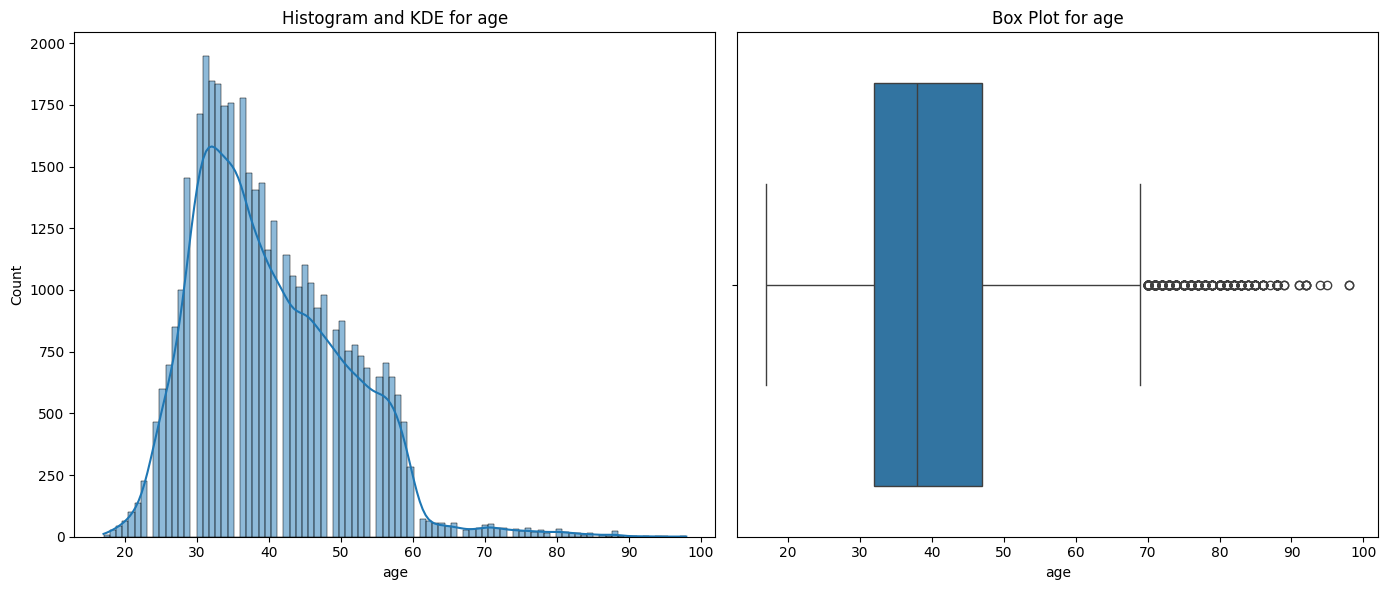


Column: age
Skewness: 0.78
Kurtosis: 0.79
Shapiro-Wilk Test: Statistic = 0.9572, P-value = 0.0000
Skipping Shapiro-Wilk test for age due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


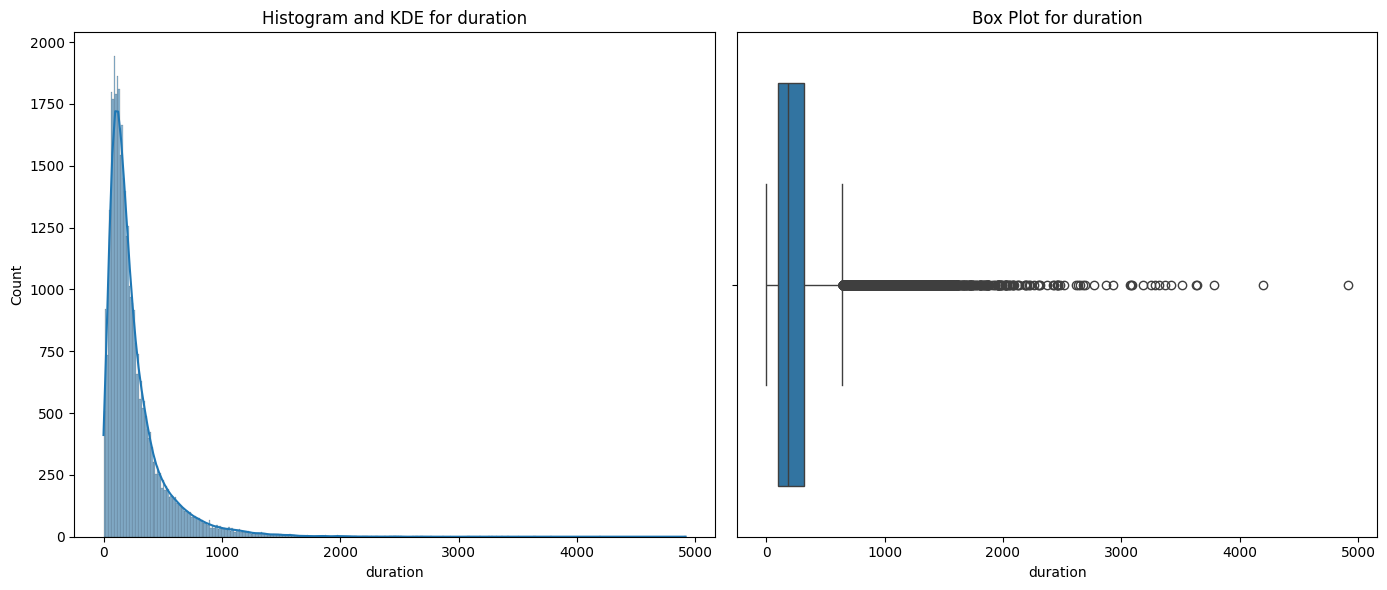


Column: duration
Skewness: 3.26
Kurtosis: 20.25
Shapiro-Wilk Test: Statistic = 0.7217, P-value = 0.0000
Skipping Shapiro-Wilk test for duration due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


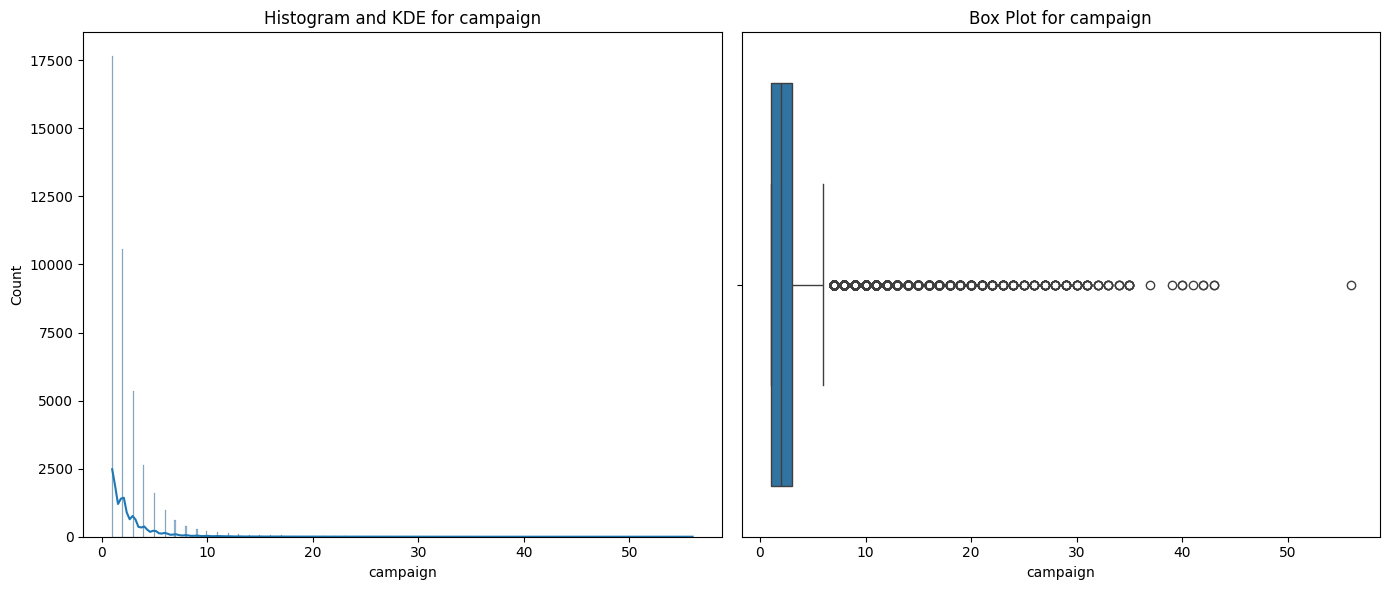


Column: campaign
Skewness: 4.76
Kurtosis: 36.98
Shapiro-Wilk Test: Statistic = 0.5578, P-value = 0.0000
Skipping Shapiro-Wilk test for campaign due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


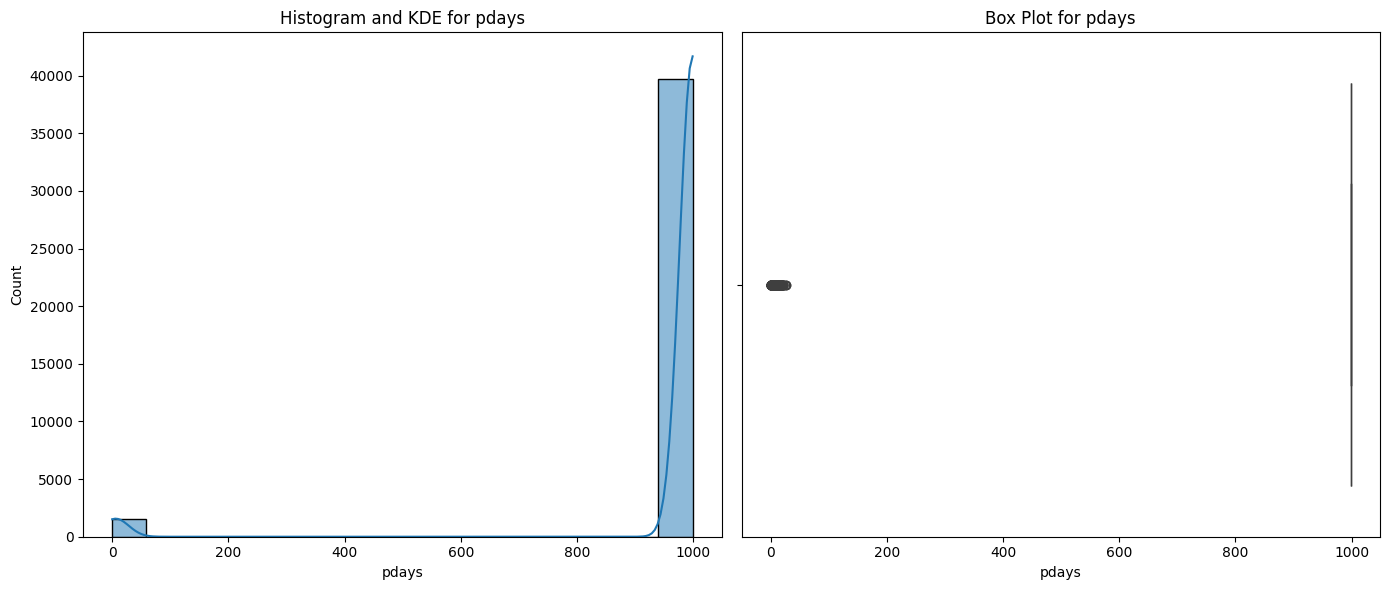


Column: pdays
Skewness: -4.92
Kurtosis: 22.23
Shapiro-Wilk Test: Statistic = 0.1830, P-value = 0.0000
Skipping Shapiro-Wilk test for pdays due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


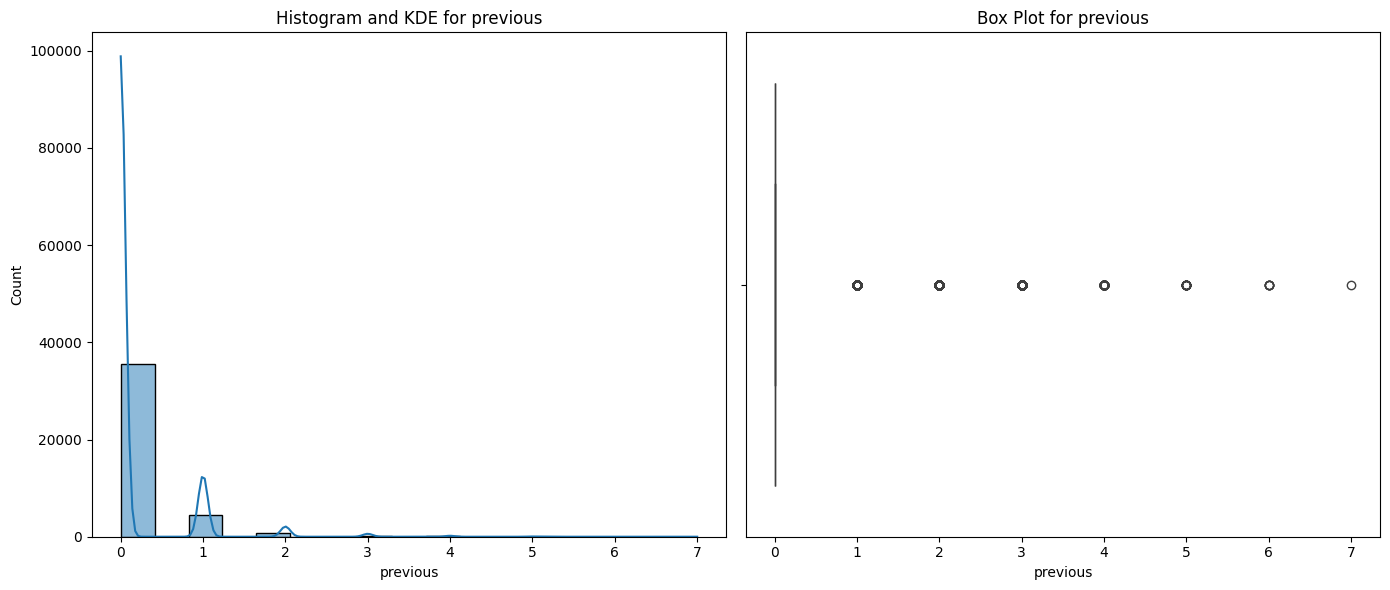


Column: previous
Skewness: 3.83
Kurtosis: 20.11
Shapiro-Wilk Test: Statistic = 0.3912, P-value = 0.0000
Skipping Shapiro-Wilk test for previous due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


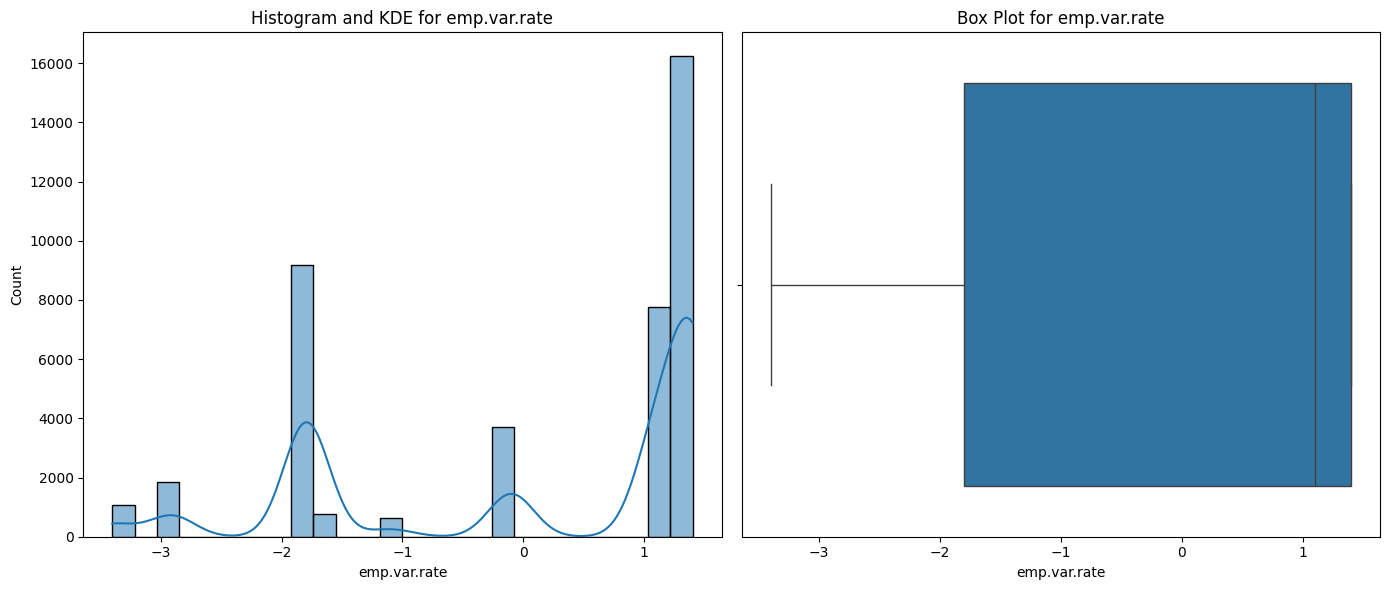


Column: emp.var.rate
Skewness: -0.72
Kurtosis: -1.06
Shapiro-Wilk Test: Statistic = 0.7621, P-value = 0.0000
Skipping Shapiro-Wilk test for emp.var.rate due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


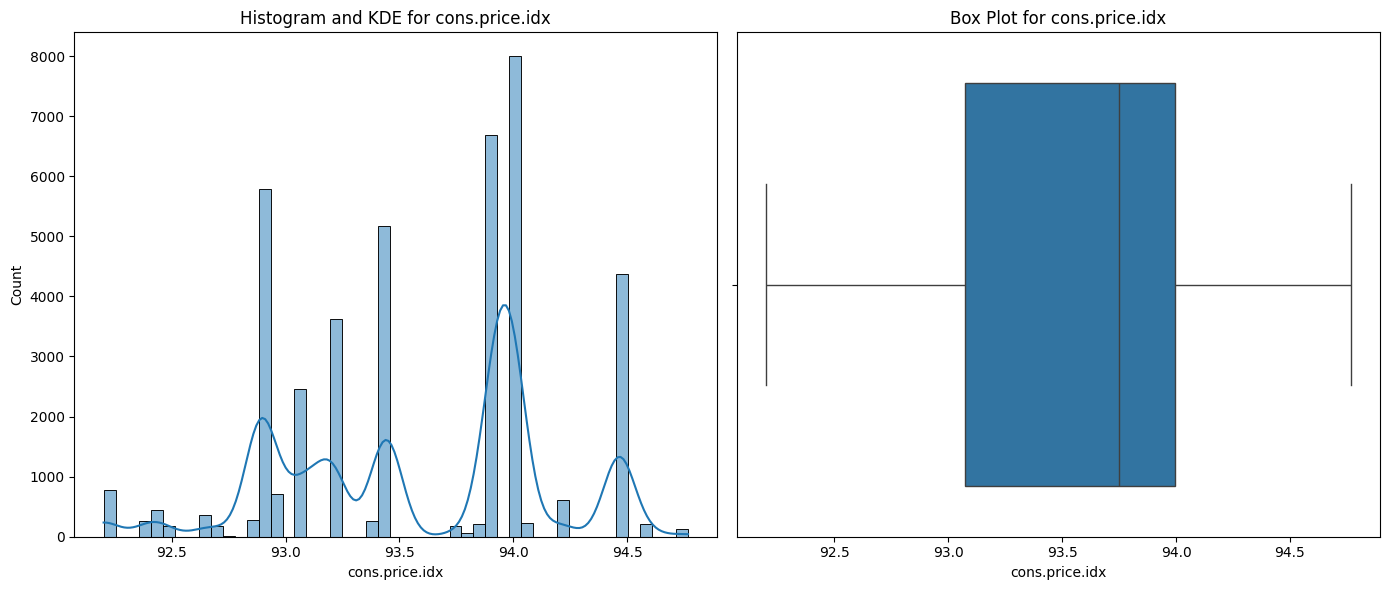


Column: cons.price.idx
Skewness: -0.23
Kurtosis: -0.83
Shapiro-Wilk Test: Statistic = 0.9340, P-value = 0.0000
Skipping Shapiro-Wilk test for cons.price.idx due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


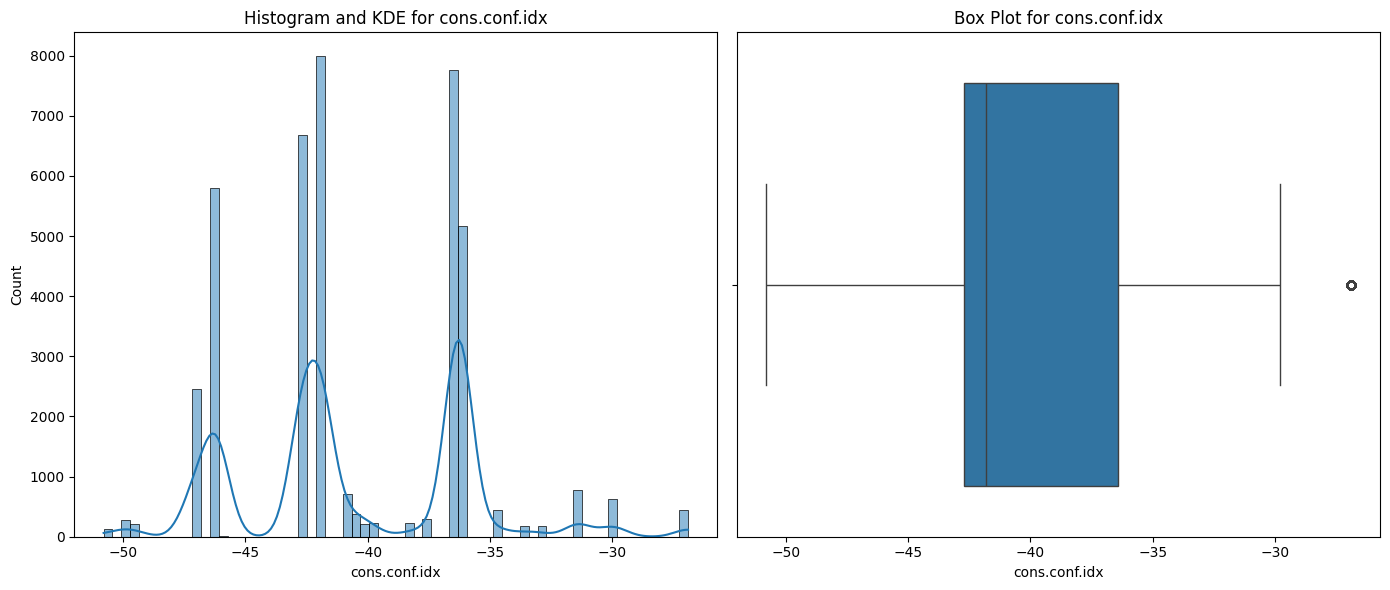


Column: cons.conf.idx
Skewness: 0.30
Kurtosis: -0.36
Shapiro-Wilk Test: Statistic = 0.9240, P-value = 0.0000
Skipping Shapiro-Wilk test for cons.conf.idx due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


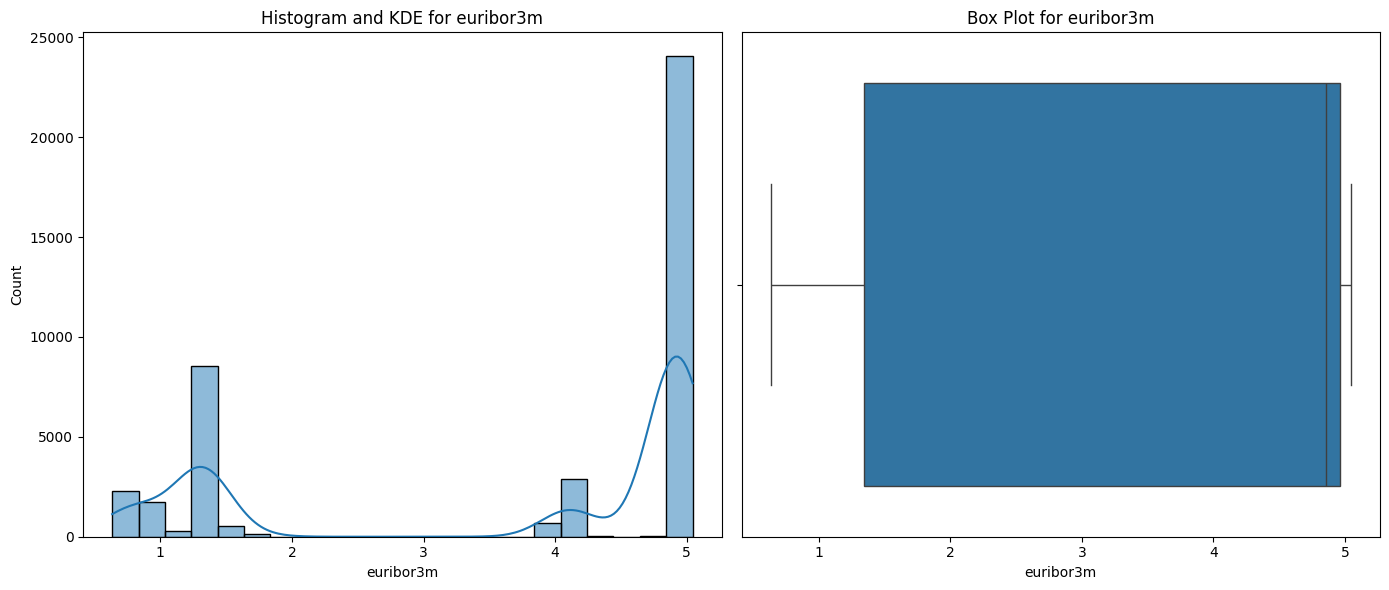


Column: euribor3m
Skewness: -0.71
Kurtosis: -1.41
Shapiro-Wilk Test: Statistic = 0.6863, P-value = 0.0000
Skipping Shapiro-Wilk test for euribor3m due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


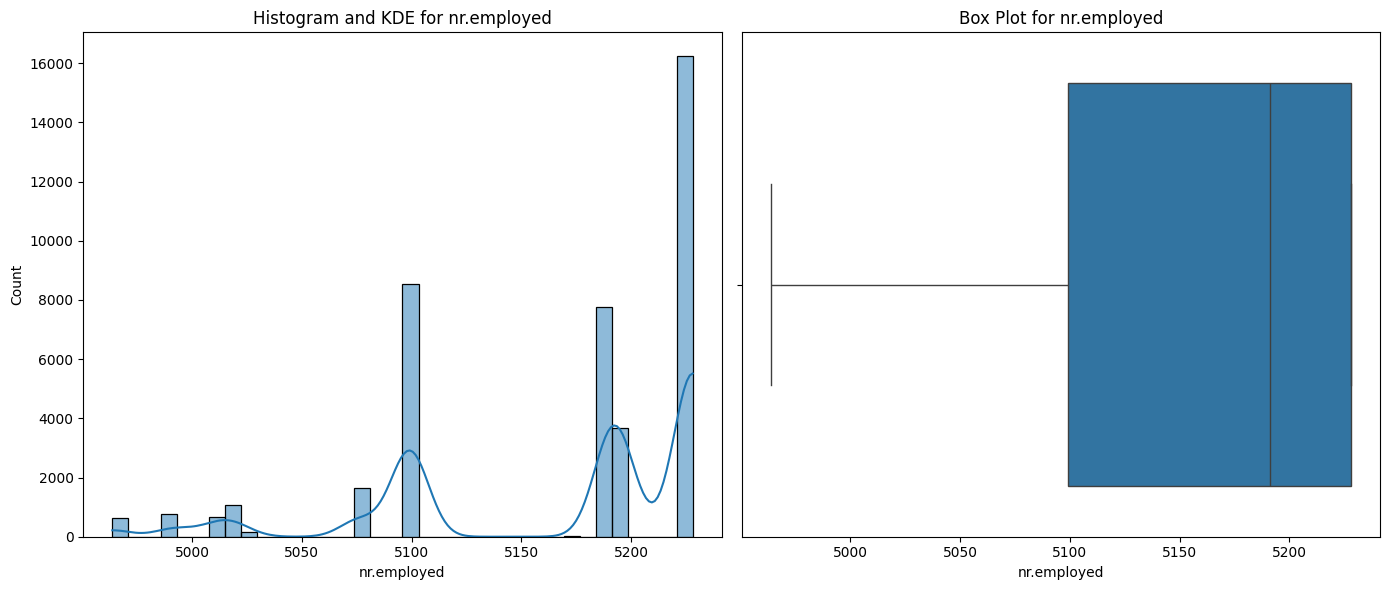


Column: nr.employed
Skewness: -1.04
Kurtosis: -0.00
Shapiro-Wilk Test: Statistic = 0.7876, P-value = 0.0000
Skipping Shapiro-Wilk test for nr.employed due to large sample size (41188 rows).
Normal distribution detected. Suggested method for outliers: Z-score.
Chosen methods for outlier detection: ['Z-score', 'Z-score', 'Z-score', 'Z-score', 'Z-score', 'Z-score', 'Z-score', 'Z-score', 'Z-score', 'Z-score']

Processing column: age with method: Z-score

Processing column: duration with method: Z-score

Processing column: campaign with method: Z-score

Processing column: pdays with method: Z-score

Processing column: previous with method: Z-score

Processing column: emp.var.rate with method: Z-score

Processing column: cons.price.idx with method: Z-score

Processing column: cons.conf.idx with method: Z-score

Processing column: euribor3m with method: Z-score

Processing column: nr.employed with method: Z-score
Outliers removed based on selected methods.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41188.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
#1.
print("\nMissing Values:\n", df.isnull().sum())
#No need to fill missing values

#2.

# Define function to plot and analyze each column
def analyze_column(df, column):

    valid_data = df[column].dropna()
    if valid_data.empty:
        print(f"Column {column} has no valid data, skipping analysis.")
        return None

    # Plot Histogram and Box Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(df[column], kde=True, ax=axes[0])  # Histogram + KDE
    axes[0].set_title(f'Histogram and KDE for {column}')
    sns.boxplot(x=df[column], ax=axes[1])  # Box Plot
    axes[1].set_title(f'Box Plot for {column}')
    plt.tight_layout()
    plt.show()

    # Calculate Skewness and Kurtosis
    column_skewness = skew(df[column], nan_policy='omit')
    column_kurtosis = kurtosis(df[column], nan_policy='omit')
    print(f'\nColumn: {column}')
    print(f'Skewness: {column_skewness:.2f}')
    print(f'Kurtosis: {column_kurtosis:.2f}')

    # Perform Shapiro-Wilk Test for normality
    stat, p_value = shapiro(df[column].dropna())
    print(f'Shapiro-Wilk Test: Statistic = {stat:.4f}, P-value = {p_value:.4f}')

 # Perform Shapiro-Wilk Test for normality (skip for large datasets)
    if len(valid_data) > 5000:
        print(f"Skipping Shapiro-Wilk test for {column} due to large sample size ({len(valid_data)} rows).")
        p_value = 1  # Assume normality since we skipped the test
    else:
        stat, p_value = shapiro(valid_data)
        print(f'Shapiro-Wilk Test: Statistic = {stat:.4f}, P-value = {p_value:.4f}')

    # Determine the method to use for outlier detection
    if p_value > 0.05:
        print(f"Normal distribution detected. Suggested method for outliers: Z-score.")
        return 'Z-score'
    else:
        if abs(column_skewness) > 1:
            print(f"Skewed distribution detected. Suggested method for outliers: IQR (due to skewness).")
            return 'IQR'
        else:
            print(f"Non-normal, but less skewed distribution. Suggested method for outliers: Modified Z-score.")
            return 'Modified Z-score'
chosen_methods = []
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns


for column in numeric_cols:
    method = analyze_column(df, column)
    chosen_methods.append(method)

print("Chosen methods for outlier detection:", chosen_methods)


# Function to remove outliers based on Z-score
def remove_zscore_outliers(df, column, threshold=3):
    z_scores = zscore(df[column].dropna())  # Compute Z-scores
    df_cleaned = df[np.abs(z_scores) <= threshold]  # Keep rows with Z-scores <= threshold
    return df_cleaned

# Function to remove outliers based on IQR
def remove_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

# Function to remove outliers based on Modified Z-score
def remove_modified_zscore_outliers(df, column, threshold=3.5):
    median = df[column].median()
    MAD = np.median(np.abs(df[column] - median))  # Median Absolute Deviation
    modified_z_scores = 0.6745 * (df[column] - median) / MAD  # Modified Z-score formula
    df_cleaned = df[np.abs(modified_z_scores) <= threshold]
    return df_cleaned



for column, method in zip(numeric_cols, chosen_methods):
    print(f"\nProcessing column: {column} with method: {method}")

    if method == 'Z-score':
        df = remove_zscore_outliers(df, column)
    elif method == 'IQR':
        df = remove_iqr_outliers(df, column)
    elif method == 'Modified Z-score':
        df = remove_modified_zscore_outliers(df, column)

print("Outliers removed based on selected methods.")


In [ ]:
# PART 3

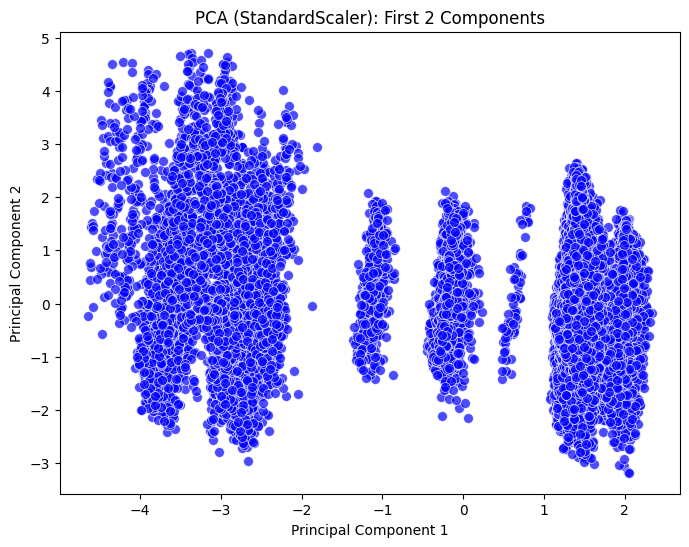

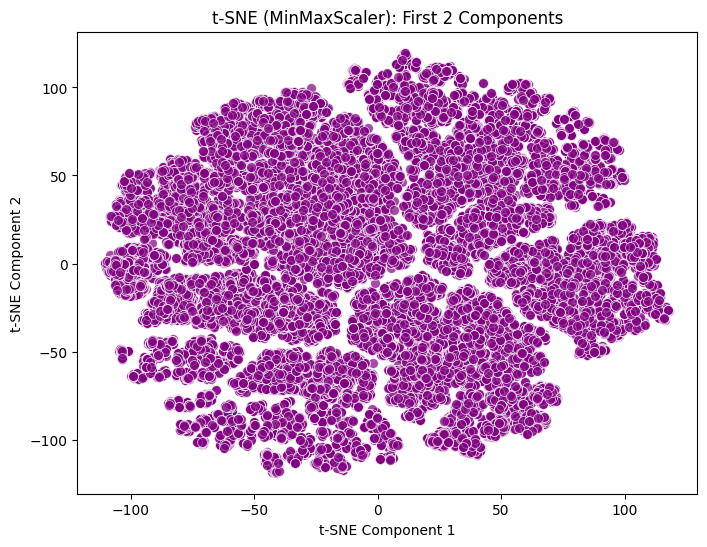

PCA Explained Variance (StandardScaler): [0.310203   0.08556569]
Total Explained Variance by 2 Components (StandardScaler): 0.40


In [ ]:

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Step 2: Scale the numerical features with both StandardScaler and MinMaxScaler
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Create two copies of the dataset
df_standard_scaled = df.copy()  # Dataset for StandardScaler
df_minmax_scaled = df.copy()



# Scale only the numerical columns using StandardScaler
df_standard_scaled[numeric_cols] = scaler_standard.fit_transform(df[numeric_cols])

# Scale only the numerical columns using MinMaxScaler
df_minmax_scaled[numeric_cols] = scaler_minmax.fit_transform(df[numeric_cols])


encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_standard = encoder.fit_transform(df[categorical_cols])
encoded_minmax = encoder.fit_transform(df[categorical_cols])


# Convert the encoded data into DataFrame for easy concatenation
encoded_df_standard = pd.DataFrame(encoded_standard, columns=encoder.get_feature_names_out(categorical_cols))
encoded_df_minmax = pd.DataFrame(encoded_minmax, columns=encoder.get_feature_names_out(categorical_cols))



#Reset indexes for both DataFrame-s before concatination
df_standard_scaled = df_standard_scaled[numeric_cols].reset_index(drop=True)
encoded_df_standard = encoded_df_standard.reset_index(drop=True)

df_minmax_scaled = df_minmax_scaled[numeric_cols].reset_index(drop=True)
encoded_df_minmax = encoded_df_minmax.reset_index(drop=True)

# Now we do concatination
df_standard_scaled = pd.concat([df_standard_scaled, encoded_df_standard], axis=1)
df_minmax_scaled = pd.concat([df_minmax_scaled, encoded_df_minmax], axis=1)


# Step 4: Apply PCA on the StandardScaler dataset
pca = PCA(n_components=2)  # Reduce to 2 components for easy visualization


pca_components_standard = pca.fit_transform(df_standard_scaled)

# Add the PCA components to the dataset
df_standard_scaled['PCA1'] = pca_components_standard[:, 0]
df_standard_scaled['PCA2'] = pca_components_standard[:, 1]


# Step 5: Apply t-SNE on the MinMaxScaler dataset
tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2 components for easy visualization
tsne_components_minmax = tsne.fit_transform(df_minmax_scaled)

# Add the t-SNE components to the dataset
df_minmax_scaled['tSNE1'] = tsne_components_minmax[:, 0]
df_minmax_scaled['tSNE2'] = tsne_components_minmax[:, 1]



# PCA visualization for StandardScaler dataset
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=df_standard_scaled, s=50, alpha=0.7, color='blue')
plt.title("PCA (StandardScaler): First 2 Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# t-SNE visualization for MinMaxScaler dataset
plt.figure(figsize=(8, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', data=df_minmax_scaled, s=50, alpha=0.7, color='purple')
plt.title("t-SNE (MinMaxScaler): First 2 Components")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Step 7: Calculate the explained variance for PCA (StandardScaler dataset)
explained_variance_standard = pca.explained_variance_ratio_
print(f"PCA Explained Variance (StandardScaler): {explained_variance_standard}")
print(f"Total Explained Variance by 2 Components (StandardScaler): {sum(explained_variance_standard):.2f}")

In [ ]:
# General Remarks: You were expected to comment and write conclusions for each section that you did. I didn’t find any conclusions in your HW, generally the score is divided by 2 in that case but as it is just the first assignment consider this as a warning and the scores are adjusted a bit because of this.

# Conclusion example: The EDA shows that variables x,y,z are normally distributed with corresponding means of a,b,c. There is high correlation between variables a, b that is why I decided to create variable d and remove variable a. I decided to fill the nan values by median because…. etc.

# Codes were well structured and you decided to implement everything from scratch ( not using package and building functions). For example you implemented by hand scaling though you could use StandardScaler or sklearn package. It is a good thing for practicing your understanding of algorithms but practically it is alway efficient to use packages and functions.
# And I didn’t get why in one case you used an implementation from scratch of scaling and in another case the package version.

# Part 1: EDA (17/30%)
# Explore the data:
# Univariate analysis: consider features separately, their distribution, descriptive statistics, anomalies, omissions, etc. (10/15%)
# When the standard deviation of a column is 0 , that means that the values are the same in the column, thus finding their outliers is meaningless. So there is redundant part in your code.
# Small remark: unknowns and NAs are the same thing in case of this dataset, I would expect to have that information in one table/ graph. As for a person reviewing it , I just saw NAN table which states that the data is clean of missing values, which is not true.
# Multivariate analysis: consider features in pairs, try to introduce new features to consider their relationship with other features, correlation, etc. (7/15%)
# 	New features were introduced in a mechanical way. If the types are int/float then create ratios, products of all possible pairs. It would be better if you dived in the meaning of the features semantically, decide what to multiply with what and explain your thinking as the explanations were provided.
# In visualizations you should always think whether the plot is readable or not, you have some pie charts where the percentages are overlapping and it is impossible to understand. You should have used parameters of matplotlib or any other library that adjusts the gridline.
# Also you have correlation matrix of all new and old features which is again very difficult to follow, i would suggest to plot it in samples, or just plot the variables that you think are more important to analyze.
# The plots and graphs should have had conclusions.
# Part 2: DP (18/20%)
# Prepare data to dimensionality reduction step:
# Fill missing values if needed, explain the selected strategy (4/5%)
# You decided not to fill NANs as there are no NA values, but what about “Unknown”.
# It is okay to leave it just as a separate category of missing/unknown but I would expect a comment on those as well.
# Deal with outliers  if needed, explain the selected strategy (5%)
# Prepare categorical and numerical data if needed, explain the selected strategy  (9/10%)
# No explanation
# Part 3: DR (25/25%)
# Use different dimensionality reduction techniques and show results:
# At least 2 different dimensionality reductions techniques: PCA, t-SNE used (possible to add SVD, NMF, UMAP) (10%)
# Add visualizations for different dimensionality reductions techniques (5%)
# Calculate explained variance for dimensionality reductions technique(s) (5%)
# Select the best number of components for dimensionality reduction technique(s) (5%)
# Part 4: General criteria for whole work (18/25% max)
# The presence of a clear structure in the work (introduction, separate sections on the issues under investigation, conclusion, further steps to take) and the presence of informative visualizations (the presence of headings, axis labels, legends, etc.)  (3/5%);
# To many plots and no explanations, difficult to follow the idea.
# Active code reuse (helper methods, classes, etc.) (5%);
# Explanations and comments regarding data actions performed (5/10%);
# Extra work that should be appreciated (5%).

# Total score- 78 %